### 🤖 What are Multi-Agent RAG Systems?
A Multi-Agent RAG System splits the RAG pipeline into multiple specialized agents — each responsible for a specific role — and enables them to collaborate on a single query or task.

#### 1. 📋 Multi-Agent Network RAG System with LangGraph
Project Overview

A Retrieval-Augmented Generation (RAG) system that uses a multi-agent architecture to intelligently answer questions from documents. Built with LangGraph v0.3 for workflow orchestration and OpenAI for language understanding.

What It Does

Transforms your documents (PDFs, text files) into a searchable knowledge base that can answer questions intelligently using AI. Simply upload documents and ask questions in natural language - the system finds relevant information and generates comprehensive answers.
Key Features

- 📚 Multi-Format Support: Handles PDF and text documents
- 🤖 3-Agent Architecture: Specialized agents for document processing, retrieval, and answer generation
- 🔍 Smart Search: Vector-based semantic search finds relevant information
- 💬 Natural Language Q&A: Ask questions in plain English


In [1]:
import os
from dotenv import load_dotenv
load_dotenv()
from langchain.chat_models import init_chat_model

os.environ["TAVILY_API_KEY"]="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"

os.environ["OPENAI_API_KEY"]=os.getenv("OPENAI_API_KEY")

In [2]:
llm=init_chat_model("openai:gpt-4o-mini")
llm

ChatOpenAI(profile={'max_input_tokens': 128000, 'max_output_tokens': 16384, 'image_inputs': True, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': False, 'tool_calling': True, 'structured_output': True, 'image_url_inputs': True, 'pdf_inputs': True, 'pdf_tool_message': True, 'image_tool_message': True, 'tool_choice': True}, client=<openai.resources.chat.completions.completions.Completions object at 0x12543e900>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x12543f380>, root_client=<openai.OpenAI object at 0x12543c1a0>, root_async_client=<openai.AsyncOpenAI object at 0x12543f0e0>, model_name='gpt-4o-mini', model_kwargs={}, openai_api_key=SecretStr('**********'), stream_usage=True)

In [3]:
from typing import Annotated

from langchain_tavily import TavilySearch
from langchain_core.tools import tool
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper
from langchain_community.document_loaders import TextLoader
from langchain_community.vectorstores import FAISS
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter

/Users/aakritinag/Documents/GitHub/Agentic-RAG/.venv/lib/python3.13/site-packages/langchain_tavily/tavily_research.py:97: UserWarning: Field name "output_schema" in "TavilyResearch" shadows an attribute in parent "BaseTool"
  class TavilyResearch(BaseTool):  # type: ignore[override, override]
/Users/aakritinag/Documents/GitHub/Agentic-RAG/.venv/lib/python3.13/site-packages/langchain_tavily/tavily_research.py:97: UserWarning: Field name "stream" in "TavilyResearch" shadows an attribute in parent "BaseTool"
  class TavilyResearch(BaseTool):  # type: ignore[override, override]


In [4]:
tavily_tool = TavilySearch(max_results = 5)

In [5]:
# generic function to create a retrieval tool
from langchain_core.tools import Tool

def make_retriever_tool_from_text(file,name,desc):
    docs=TextLoader(file,encoding="utf-8").load()
    chunks = RecursiveCharacterTextSplitter(chunk_size=500, chunk_overlap=50).split_documents(docs)
    vs = FAISS.from_documents(chunks, OpenAIEmbeddings())
    retriever = vs.as_retriever()

    def tool_func(query:str)->str:
        print(f"📚 Using tool: {name}")
        results = retriever.invoke(query)
        return "\n\n".join(doc.page_content for doc in results)
    
    return Tool(name=name,description=desc,func=tool_func)


internal_tool_1 = make_retriever_tool_from_text("internal_docs.txt",
                                              "InternalResearchNotes",
                                              "Search internal research notes for experimental results")

internal_tool_1

Tool(name='InternalResearchNotes', description='Search internal research notes for experimental results', func=<function make_retriever_tool_from_text.<locals>.tool_func at 0x133173920>)

In [6]:
from langchain_core.messages import BaseMessage, HumanMessage
from langchain.agents import create_agent
from langgraph.graph import MessagesState, END
from langgraph.types import Command

def get_next_node(last_message: BaseMessage, goto: str):
    if "FINAL ANSWER" in last_message.content:
        # Any agent decided the work is done
        return END
    return goto

In [7]:
def make_system_prompt(suffix: str) -> str:
    return (
        "You are a helpful AI assistant, collaborating with other assistants."
        " Use the provided tools to progress towards answering the question."
        " If you are unable to fully answer, that's OK, another assistant with different tools "
        " will help where you left off. Execute what you can to make progress."
        " If you or any of the other assistants have the final answer or deliverable,"
        " prefix your response with FINAL ANSWER so the team knows to stop."
        f"\n{suffix}"
    )

In [8]:
# Reaearch agent and node
from langchain_core.messages import SystemMessage

system_msg = SystemMessage(
    content="You can only do research. Use only bound tools. "
            "You are collaborating with a content writer."
)

llm_with_prompt = llm.bind(messages=[system_msg])

research_agent = create_agent(
    llm_with_prompt,
    tools=[internal_tool_1, tavily_tool]
)


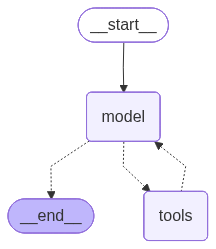

In [9]:
research_agent

In [10]:
# ## Reaearch node
# from typing import Literal

# def research_node(state:MessagesState)-> Command[Literal["blog_generator",END]]:
#     result = research_agent.invoke(state)
#     goto = get_next_node(result["messages"][-1], "blog_generator")

#     # wrap in a human message, as not all providers allow
#     # AI message at the last position of the input messages list
#     result["messages"][-1] = HumanMessage(
#         content=result["messages"][-1].content, name="researcher"
#     )
#     return Command(
#         update={
#             # share internal message history of research agent with other agents
#             "messages": result["messages"],
#         },
#         goto=goto,
#     )


In [11]:
from typing import Literal
def research_node(state: MessagesState) -> Command[Literal["blog_generator", END]]:
    result = research_agent.invoke(state)

    # always hand off once to blog
    goto = "blog_generator"

    # If researcher already produced final, end
    if "final answer" in (result["messages"][-1].content or "").lower():
        goto = END

    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content, name="researcher"
    )
    return Command(update={"messages": result["messages"]}, goto=goto)


In [12]:
# # Create blog agent 
# blog_agent = create_agent(
#     llm,
#     tools=[]
# )

# BLOG_SYSTEM = "You can only write a detailed blog. You are working with a researcher colleague."

# def blog_node(state: MessagesState) -> Command[Literal["researcher", END]]:
#     # Inject system message at runtime
#     state_with_system = {
#         **state,
#         "messages": [SystemMessage(content=BLOG_SYSTEM)] + state["messages"]
#     }

#     result = blog_agent.invoke(state_with_system)

#     goto = get_next_node(result["messages"][-1], "researcher")

#     # Wrap final assistant output as HumanMessage for provider compatibility
#     result["messages"][-1] = HumanMessage(
#         content=result["messages"][-1].content,
#         name="blog_generator"
#     )

#     return Command(
#         update={"messages": result["messages"]},
#         goto=goto,
#     )


In [13]:
from langgraph.graph import END

blog_agent = create_agent(
    llm,
    tools=[]
)

BLOG_SYSTEM = "You can only write a detailed blog. You are working with a researcher colleague."

def blog_node(state: MessagesState) -> Command[Literal["researcher", END]]:
    # add system only once
    messages = state["messages"]
    if not (messages and isinstance(messages[0], SystemMessage) and messages[0].content == BLOG_SYSTEM):
        messages = [SystemMessage(content=BLOG_SYSTEM)] + messages

    result = blog_agent.invoke({**state, "messages": messages})

    # default: stop
    goto = END
    text = (result["messages"][-1].content or "").lower()
    if "need more research" in text or "need sources" in text or "researcher" in text:
        goto = "researcher"

    result["messages"][-1] = HumanMessage(
        content=result["messages"][-1].content,
        name="blog_generator"
    )
    return Command(update={"messages": result["messages"]}, goto=goto)


In [16]:
from langgraph.graph import StateGraph, START, END
from langgraph.graph import MessagesState

workflow = StateGraph(MessagesState)

workflow.add_node("researcher", research_node)
workflow.add_node("blog_generator", blog_node)

# one pass flow
workflow.add_edge(START, "researcher")
workflow.add_edge("researcher", "blog_generator")
workflow.add_edge("blog_generator", END)

graph = workflow.compile()


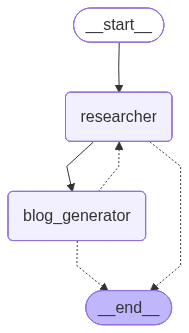

In [17]:
graph

In [18]:
from langchain_core.messages import HumanMessage

response = graph.invoke({
    "messages": [HumanMessage(content="Write a detailed blog on transformer variants for production")]
})


In [19]:
response["messages"][-1].content

'# Understanding Transformer Variants for Production: A Deep Dive\n\nIn the rapidly evolving landscape of machine learning and artificial intelligence, Transformers have emerged as a groundbreaking architecture. Originally designed for natural language processing (NLP), Transformers have found applications across diverse fields, including image processing, audio synthesis, and even genomics. As the demand for more efficient, scalable, and powerful models grows, various Transformer variants have been developed to address specific challenges and optimize performance in production environments. This blog aims to provide an in-depth overview of notable Transformer variants, their architectures, applications, and considerations for use in production settings.\n\n## 1. The Original Transformer Model\n\nBefore delving into the variants, it\'s essential to comprehend the original Transformer model introduced in the seminal paper "Attention Is All You Need" by Vaswani et al. in 2017. The Transf